# Modelling

In [96]:
import pandas as pd
import matplotlib.pyplot as plt

In [97]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, plot_roc_curve, roc_auc_score, recall_score, precision_score, f1_score

from imblearn.over_sampling import SMOTE

In [98]:
def append_results(result, train_score, metric, classifier):
    tmp = pd.DataFrame({
        'model':classifier,
        'train_accuracy': train_score,
        'test_accuracy': metric[metric['metric'] == 'accuracy']['score'].values[0],
        'misclassification': metric[metric['metric'] == 'misclassification_rate']['score'].values[0],
        'sensitivity': metric[metric['metric'] == 'sensitivity']['score'].values[0],
        'specificity': metric[metric['metric'] == 'specificity']['score'].values[0],
        'precision': metric[metric['metric'] == 'precision']['score'].values[0],
        'f1_score': metric[metric['metric'] == 'f1_score']['score'].values[0],
        'roc_auc':metric[metric['metric'] == 'roc_auc']['score'].values[0],
        #'misclassed_data':misclass_data
    }, index=[0])
    result = pd.concat([result,tmp], axis=0, ignore_index=True)
    return result

In [99]:
def metrics_and_plot_cm(classifier, X, y):
    preds = classifier.predict(X)
    tn, fp, fn, tp = confusion_matrix(y, preds).ravel()
    acc = (tp + tn) / (tn + fp + fn + tp)
    misclass = 1 - acc
    sens = tp / (tp + fn)
    spec = tn / (tn + fp)
    prec = tp / (tp + fp)
    f_one_score = f1_score(y, preds)
    roc_auc = roc_auc_score(y, classifier.predict_proba(X)[:,1])
    results = {
        'accuracy': acc,
        'misclassification_rate': misclass,
        'sensitivity': sens,
        'specificity': spec,
        'precision': prec,
        'f1_score':f_one_score,
        'roc_auc':roc_auc
    }
    fig, axes = plt.subplots(ncols=2, figsize=(13,5))
    cm_chart = plot_confusion_matrix(classifier, X, y, cmap='Blues', values_format='d', ax=axes[0]);
    # cm_chart = plot_confusion_matrix(classifier, X, y, cmap='Blues', values_format='d',display_labels=['WNV Not Present (0)','WNV Present (1)'], ax=axes[0]);
    roc_curve = plot_roc_curve(classifier, X, y, ax=axes[1])
    axes[1].plot([0, 1], [0, 1], label='baseline', linestyle='--' )
    metrics = pd.DataFrame({
        'metric': results.keys(),
        'score': results.values()
        })
    return metrics

In [ ]:
train_comb = pd.read_csv('./assets/train_comb.csv')

In [ ]:
train_comb['date'] = pd.to_datetime(train_comb['date'])
train_comb.set_index('date', inplace=True)

In [ ]:
# dropping trap column for now as it is not numeralize yet
X = train_comb.drop(columns=['wnvpresent', 'trap'])
y = train_comb['wnvpresent']

In [ ]:
# train/test split on data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [ ]:
# Scale X data
ss = StandardScaler()
Xs_train, Xs_val = ss.fit_transform(X_train), ss.transform(X_val)

In [103]:
X_train = pd.read_csv('./assets/X_train.csv')
y_train = pd.read_csv('./assets/y_train.csv')
X_test = pd.read_csv('./assets/test_final.csv')

# To remove once NaN are fixed in Part 1
# X_test['species_rank'].fillna(0, inplace=True)
# X_test['trap_rank'].fillna(0, inplace=True)
X_train.drop(columns=['Unnamed: 0'], inplace=True)
y_train.drop(columns=['Unnamed: 0'], inplace=True)
# X_test.drop(columns=['Unnamed: 0','index'], inplace=True)

In [101]:
X_train.shape

(8304, 179)

In [102]:
y_train.shape

(8304, 1)

(116293, 182)

In [105]:
Xs_train, Xs_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

## Baseline Score

In [ ]:
train_comb['wnvpresent'].value_counts(normalize=True)

The baseline accuracy score would be 0.948.

In [106]:
results_df = pd.DataFrame(columns=[
    'model',
    'train_accuracy',
    'test_accuracy',
    'misclassification',
    'sensitivity',
    'specificity',
    'precision',
    'f1_score',
    'roc_auc'
])

## Account for Imbalanced Class

We note from our target column: 'wnvpresent' that there is massive class imbalance. We can resolve this by using SMOTE and embed it within a pipeline.

In [ ]:
# sm = SMOTE()

In [ ]:
# Xsm_train, ysm_train = sm.fit_resample(Xs_train, y_train)

## Logistic Regression

In [107]:
# instantiate pipeline
pipe_logreg = Pipeline([('sampling', SMOTE(random_state=100)),
                ('logreg', LogisticRegression(solver='liblinear', random_state=100))
                ])

In [108]:
# set params to gridsearch
# sampling params set to comment because it was taking too long to fit
pipe_logreg_params = {
    'logreg__penalty': ['l1','l2'],
    'logreg__C': [0.5, 1, 1.5, 2],
    'sampling__sampling_strategy': ['not majority','auto'],
    'sampling__k_neighbors': [3, 5],
}

In [109]:
gs_logreg = GridSearchCV(pipe_logreg, pipe_logreg_params, verbose=2, n_jobs=-1)

In [ ]:
%%time
gs_logreg.fit(Xs_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


In [ ]:
gs_logreg.best_params_

In [ ]:
mod_metrics = metrics_and_plot_cm(gs_logreg, Xs_val, y_val)

In [ ]:
results_df = append_results(results_df,
                           gs_logreg.score(Xs_train, y_train),
                           mod_metrics,
                           'Logistic Regression',
                           )

In [ ]:
results_df

## SVM

In [24]:
# instantiate pipeline
pipe_svc = Pipeline([('sampling', SMOTE()),
                 ('svc', SVC(probability=True, random_state=100)) # probability=True is needed to calculate predict_proba but fitting grid model would take very long
                ])

In [25]:
pipe_svc_params = {
    'svc__C': [5, 7, 9],
    'svc__kernel': ['rbf'],  #'poly'
    #'sampling__sampling_strategy': ['minority', 'not minority', 'auto'],
    #'sampling__k_neighbors': [3, 5],      
}

In [26]:
gs_svc = GridSearchCV(pipe_svc, pipe_svc_params, verbose=2, n_jobs=-1)

In [27]:
%%time
gs_svc.fit(Xs_train, y_train)

# wall time is cut by half we dont put SVC(probability=True) in the pipeline

Fitting 5 folds for each of 3 candidates, totalling 15 fits


C:\Users\Seraphim\anaconda3\envs\dsi\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Wall time: 56.5 s


GridSearchCV(estimator=Pipeline(steps=[('sampling', SMOTE()),
                                       ('svc',
                                        SVC(probability=True,
                                            random_state=100))]),
             n_jobs=-1,
             param_grid={'svc__C': [5, 7, 9], 'svc__kernel': ['rbf']},
             verbose=2)

In [28]:
gs_svc.best_params_

{'svc__C': 9, 'svc__kernel': 'rbf'}

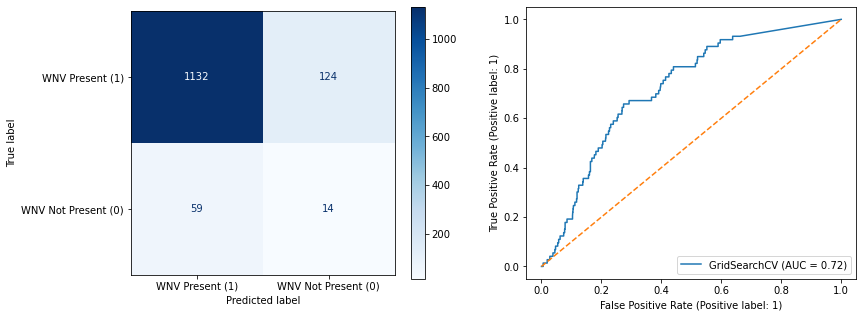

In [29]:
mod_metrics = metrics_and_plot_cm(gs_svc, Xs_val, y_val)

In [30]:
results_df = append_results(results_df,
                           gs_svc.score(Xs_train, y_train),
                           mod_metrics,
                           'SVM',
                           )

In [31]:
results_df

,model,train_accuracy,test_accuracy,misclassification,sensitivity,specificity,precision,f1_score,roc_auc
0,Logistic Regression,0.703425,0.720090,0.279910,0.780822,0.716561,0.138015,0.234568,0.773776
1,SVM,0.950508,0.862302,0.137698,0.191781,0.901274,0.101449,0.132701,0.722297


## PCA

In [32]:
# instantiate pca
pca = PCA(random_state=100)

In [33]:
pca.fit(Xs_train)

PCA(random_state=100)

In [34]:
Z_train, Z_val = pca.transform(Xs_train), pca.transform(Xs_val)

In [35]:
pca.explained_variance_ratio_.round(3)

array([0.319, 0.169, 0.084, 0.072, 0.069, 0.065, 0.048, 0.029, 0.019,
       0.015, 0.01 , 0.009, 0.006, 0.006, 0.006, 0.005, 0.004, 0.004,
       0.003, 0.003, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002,
       0.002, 0.002, 0.002, 0.002, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ])

In [36]:
pca.explained_variance_ratio_.round(3)[:10].sum()

0.889

We see that the first 10 components explain 77% of the variance.

In [37]:
pca.explained_variance_ratio_.round(3)[:25].sum()

0.9550000000000001

The first 25 component explain 100% of the variance.

### Logistic Regression with PCA

In [38]:
# embed pca in a pipeline
pipe_pca_logreg = Pipeline([('sampling', SMOTE()),
                 ('pca', PCA()),
                 ('logreg', LogisticRegression(solver='liblinear', random_state=100))
                ])

In [39]:
pipe_pca_logreg_params = {
    'logreg__penalty': ['l1','l2'],
    'logreg__C': [1, 1.5, 2],
    'pca__n_components': [20, 30, 40]
    #'sampling__sampling_strategy': ['minority', 'not minority', 'auto'],
    #'sampling__k_neighbors': [3, 5],
}

In [40]:
gs_pca_logreg = GridSearchCV(pipe_pca_logreg, pipe_pca_logreg_params, verbose=2, n_jobs=-1)

In [41]:
%%time
gs_pca_logreg.fit(Xs_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Wall time: 4.64 s


C:\Users\Seraphim\anaconda3\envs\dsi\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


GridSearchCV(estimator=Pipeline(steps=[('sampling', SMOTE()), ('pca', PCA()),
                                       ('logreg',
                                        LogisticRegression(random_state=100,
                                                           solver='liblinear'))]),
             n_jobs=-1,
             param_grid={'logreg__C': [1, 1.5, 2],
                         'logreg__penalty': ['l1', 'l2'],
                         'pca__n_components': [20, 30, 40]},
             verbose=2)

In [42]:
gs_pca_logreg.best_params_

{'logreg__C': 1, 'logreg__penalty': 'l1', 'pca__n_components': 40}

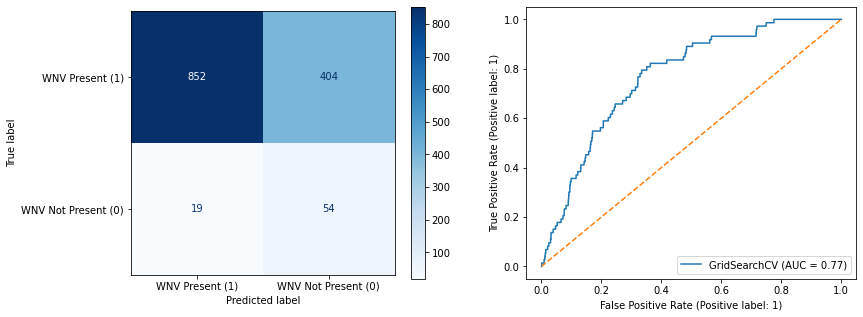

In [43]:
mod_metrics = metrics_and_plot_cm(gs_pca_logreg, Xs_val, y_val)

In [44]:
results_df = append_results(results_df,
                           gs_pca_logreg.score(Xs_train, y_train),
                           mod_metrics,
                           'PCA Logistic Regression',
                           )

In [45]:
results_df

,model,train_accuracy,test_accuracy,misclassification,sensitivity,specificity,precision,f1_score,roc_auc
0,Logistic Regression,0.703425,0.720090,0.279910,0.780822,0.716561,0.138015,0.234568,0.773776
1,SVM,0.950508,0.862302,0.137698,0.191781,0.901274,0.101449,0.132701,0.722297
2,PCA Logistic Regression,0.679338,0.681716,0.318284,0.739726,0.678344,0.117904,0.203390,0.770275


### SVM with PCA

In [46]:
pipe_pca_svc = Pipeline([('sampling', SMOTE()),
                 ('pca', PCA()),
                 ('svc', SVC(probability=True, random_state=100))
])

In [47]:
pipe_pca_svc_params = {
    'svc__C': [5, 7, 9],
    'svc__kernel': ['rbf'],  # 'poly'
    'pca__n_components': [20, 30, 40]
    #'sampling__sampling_strategy': ['minority', 'not minority', 'auto'],
    #'sampling__k_neighbors': [3, 5],      
}

In [48]:
gs_pca_svc = GridSearchCV(pipe_pca_svc, pipe_pca_svc_params, verbose=2, n_jobs=-1)

In [49]:
%%time
gs_pca_svc.fit(Xs_train, y_train)

## lol example of time taken (14 mins) if we put SVC(probability=True) in the pipeline

Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\Seraphim\anaconda3\envs\dsi\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Wall time: 1min 19s


GridSearchCV(estimator=Pipeline(steps=[('sampling', SMOTE()), ('pca', PCA()),
                                       ('svc',
                                        SVC(probability=True,
                                            random_state=100))]),
             n_jobs=-1,
             param_grid={'pca__n_components': [20, 30, 40], 'svc__C': [5, 7, 9],
                         'svc__kernel': ['rbf']},
             verbose=2)

In [50]:
gs_pca_svc.best_params_

{'pca__n_components': 40, 'svc__C': 9, 'svc__kernel': 'rbf'}

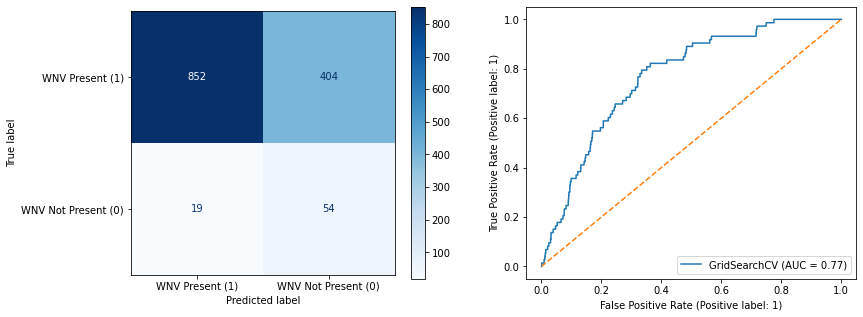

In [51]:
mod_metrics = metrics_and_plot_cm(gs_pca_logreg, Xs_val, y_val)

In [52]:
results_df = append_results(results_df,
                           gs_pca_svc.score(Xs_train, y_train),
                           mod_metrics,
                           'PCA SVM',
                           )

In [53]:
results_df

,model,train_accuracy,test_accuracy,misclassification,sensitivity,specificity,precision,f1_score,roc_auc
0,Logistic Regression,0.703425,0.720090,0.279910,0.780822,0.716561,0.138015,0.234568,0.773776
1,SVM,0.950508,0.862302,0.137698,0.191781,0.901274,0.101449,0.132701,0.722297
2,PCA Logistic Regression,0.679338,0.681716,0.318284,0.739726,0.678344,0.117904,0.203390,0.770275
3,PCA SVM,0.908355,0.681716,0.318284,0.739726,0.678344,0.117904,0.203390,0.770275


## AdaBoost

To remove as it's not the best performing classifier.

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [ ]:
pipe_ada = Pipeline([
    ('sampling', SMOTE()),
    ('ada', AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=100)))
])

In [ ]:
pipe_ada_params = {
    'ada__n_estimators': [50,100,150],
    'ada__learning_rate': [0.1,1,10]
}

In [ ]:
gs_ada = GridSearchCV(pipe_ada, pipe_ada_params, verbose=1, n_jobs=-1)

In [ ]:
gs_ada.fit(Xs_train, y_train)

In [ ]:
gs_ada.best_params_

In [ ]:
mod_metrics = metrics_and_plot_cm(gs_ada, Xs_val, y_val)

In [ ]:
results_df = append_results(results_df,
                           gs_ada.score(Xs_train, y_train),
                           mod_metrics,
                           'AdaBoost',
                           )

In [ ]:
results_df

# Predicting with Test Data

We utilise the whole train set as our train data here, and the test data to predict the probabilities, which will then be submitted to Kaggle for scoring.

In [ ]:
X_train = pd.read_csv('./assets/X_train.csv')
y_train = pd.read_csv('./assets/y_train.csv')
X_test = pd.read_csv('./assets/test_final.csv')

In [ ]:
# To remove once NaN are fixed in Part 1
X_test['species_rank'].fillna(0, inplace=True)
X_test['trap_rank'].fillna(0, inplace=True)

In [ ]:
X_train.drop(columns=['Unnamed: 0'], inplace=True)
y_train.drop(columns=['Unnamed: 0'], inplace=True)
X_test.drop(columns=['Unnamed: 0','index'], inplace=True)

In [ ]:
X_test.set_index('id', inplace=True)

In [ ]:
gs_logreg.fit(X_train, y_train)
gs_svc.fit(X_train, y_train)
gs_pca_logreg.fit(X_train, y_train)
gs_pca_svc.fit(X_train, y_train)
gs_ada.fit(X_train, y_train)

In [ ]:
def output_results(preds, filename):
    preds_to_df = pd.DataFrame(preds, columns=['0','1'])
    preds_to_df.drop('0',axis=1, inplace=True)
    preds_to_df.rename(columns={'1':'Wnvpresent'}, inplace=True)
    preds_to_df.index.rename('id', inplace=True)
    preds_to_df.index += 1
    preds_to_df.to_csv(f'./assets/{filename}.csv', index=True)

In [ ]:
output_results(gs_logreg.predict_proba(X_test), 'logreg_results')
output_results(gs_svc.predict_proba(X_test), 'svc_results')
output_results(gs_pca_logreg.predict_proba(X_test), 'pca_logreg_results')
output_results(gs_pca_svc.predict_proba(X_test), 'pca_svc_results')
output_results(gs_ada.predict_proba(X_test), 'ada_results')

In [ ]:
# preds_to_df = pd.DataFrame(preds, columns=['0','1'])
# preds_to_df.drop('0',axis=1, inplace=True)
# preds_to_df.rename(columns={'1':'Wnvpresent'}, inplace=True)
# preds_to_df.index.rename('id', inplace=True)
# preds_to_df.index += 1
# preds_to_df.to_csv('./assets/results.csv', index=True)

# Feature Importance

In [ ]:
# note: svm on rbf has no feature importance, only svm on linear has it
# https://stackoverflow.com/questions/41592661/determining-the-most-contributing-features-for-svm-classifier-in-sklearn

Feature Importance based on Logistic Regression

In [ ]:
gs_logreg.best_estimator_[1].coef_

In [ ]:
logreg_features = pd.DataFrame({'feature_names': X_train.columns,
                                'feature_importance': gs_logreg.best_estimator_[1].coef_[0]})

# top 20 features
logreg_features.sort_values(by='feature_importance', ascending=False).head(20)

# Cost Benefit Analysis

# Conclusion